# 3) Reconstruct target file with audio frames from source collection

In [1]:
import os
import pandas as pd
import essentia
import essentia.standard as estd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, Audio

DATASET_FILENAME = 'dataset.csv'
MOSAICING_DATASET_FILENAME = 'dataset_mosaicing.csv'
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'
TARGET_SOUND_PATH = 'target.mp3'
GENERATED_AUDIO_FILENAME = '{0}.mosaic.wav'.format(TARGET_SOUND_PATH)
SIMILARITY_FEATURES = ['mfcc_{0}'.format(i) for i in range(0, 13)]  # Use MFCCs for sound similarity
    
df = pd.read_csv(open(DATASET_FILENAME), index_col=0)
df_mosaicing = pd.read_csv(open(MOSAICING_DATASET_FILENAME), index_col=0)
df_target = pd.read_csv(open(DATAFRAME_TARGET_FILE_FILENAME), index_col=0)

In [2]:
loaded_audio_files = {}

def get_audio_file_segment(file_path, start_sample, n_samples):
    
    # Load audio file. Try to get it from memory first. If not there, open it and save in memory for next time.
    if file_path not in loaded_audio_files:
        loader = estd.MonoLoader(filename=file_path)
        audio = loader()
        loaded_audio_files[file_path] = audio
    else:
        audio = loaded_audio_files[file_path]
        
    # Return segment
    return audio[start_sample:start_sample + n_samples]

def find_similar_frames(query_frame, source_data_frame, n, features):
    #query_point = target_data_frame[features].as_matrix()[target_data_frame_index].reshape(1,-1)
    query_frame = query_frame.reshape(1,-1)
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='ball_tree').fit(source_data_frame[features].as_matrix())
    distances, indices = nbrs.kneighbors(query_frame)
    return [source_data_frame.iloc[i] for i in indices]

In [3]:
loader = estd.MonoLoader(filename=TARGET_SOUND_PATH)
target_audio = loader()

total_length_target_audio = len(target_audio)
generated_audio = np.zeros(total_length_target_audio)

for i in range(0, len(df_target)):
    target_frame = df_target.iloc[i]
    
    # Find the most similar frame to target_frameframe_data from df_mosaicing
    query_frame = target_frame[SIMILARITY_FEATURES].as_matrix()
    similar_frames = find_similar_frames(query_frame, df_mosaicing, 1, SIMILARITY_FEATURES)
    most_similar_frame = similar_frames[0]
    most_similar_frame = most_similar_frame.iloc[0]
    
    # Get the audio segment corresponding to the most similar frame
    target_frame_n_samples = min(target_frame['end_sample'], total_length_target_audio) - target_frame['start_sample']
    most_similar_frame_audio = get_audio_file_segment(most_similar_frame['path'], most_similar_frame['start_sample'], target_frame_n_samples)
    
    # Add audio segment to the constructed out audio
    generated_audio[target_frame['start_sample']:target_frame['start_sample']+target_frame_n_samples] = most_similar_frame_audio

estd.MonoWriter(filename=GENERATED_AUDIO_FILENAME, format='wav', sampleRate=44100)(essentia.array(generated_audio))
print('Audio generated and saved in {0}!'.format(GENERATED_AUDIO_FILENAME))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Audio generated and saved in target.mp3.mosaic.wav!


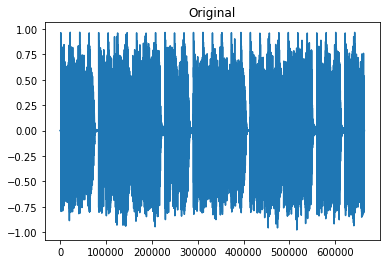

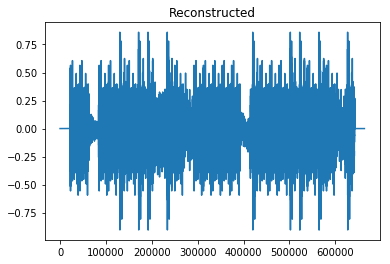

Original


Reconstructed


Mix of both signals


In [5]:
# Plot waveforms
plt.plot(target_audio)
plt.title('Original')
plt.show()

plt.plot(generated_audio)
plt.title('Reconstructed')
plt.show()

# Show audio players
print('Original')
display(Audio(target_audio, rate=44100))

print('Reconstructed')
display(Audio(generated_audio, rate=44100))

print('Mix of both signals')
display(Audio(generated_audio * 0.5 + target_audio * 0.5, rate=44100))